<h1 style='color:orange; font-weight:bold; text-align:center'>Sentiment Prediction with TF-IDF Representation: A Conventional Machine Learning Approach</h1>

## **1 Introduction**
Source: [Kaggle](https://www.kaggle.com/datasets/jocelyndumlao/prdect-id-indonesian-emotion-classification)

## **2 Data Preparation**

In [1]:
# DATA EXPLORATION
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

# MODELING
import time
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import make_scorer, accuracy_score, precision_score
from sklearn.metrics import  recall_score, f1_score, hamming_loss
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

# ML EVALUATION & EXPLAINABLE AI
from sklearn.model_selection import LearningCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix
import eli5
from lime.lime_text import LimeTextExplainer
from sklearn.inspection import permutation_importance
import joblib

In [2]:
# load dataset
df = pd.read_csv('../data/PRDECT-ID Dataset.csv')
# df = pd.read_csv('/content/drive/MyDrive/PORTFOLIOS/NLP-PROJECTS/SENTIMENT-ANALYSIS/data/PRDECT-ID Dataset.csv')

In [3]:
# function to inspect dataframe
def inspect_dataframe(df):
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean()*100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValues': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [4]:
# inspect dataframe
print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols')
print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
inspect_dataframe(df)

The dataframe contains 5400 rows and 11 cols
- 5 are numeric cols
- 6 are object cols


ColumnName  Nrow DataType  NAPct  DuplicatePct  UniqueValues  \
0          Category  5400   object    0.0          0.13            29   
1      Product Name  5400   object    0.0          0.13          1308   
2          Location  5400   object    0.0          0.13            61   
3             Price  5400    int64    0.0          0.13           555   
4    Overall Rating  5400  float64    0.0          0.13            10   
5       Number Sold  5400    int64    0.0          0.13          1043   
6      Total Review  5400    int64    0.0          0.13           958   
7   Customer Rating  5400    int64    0.0          0.13             5   
8   Customer Review  5400   object    0.0          0.13          5305   
9         Sentiment  5400   object    0.0          0.13             2   
10          Emotion  5400   object    0.0          0.13             5   

                                               Sample  
0   [Computers and Laptops, Toys and Hobbies, Food...  
1   [Wireless Keyboard i8 Mini TouchPad Mouse 2.4G...  
2   [Jakarta Utara, Kota Tangerang Selatan, Jakart...  
3   [53500, 72000, 213000, 55000, 85000, 136500, 1...  
4   [4.9, 5.0, 4.7, 4.8, 4.3, 4.6, 4.4, 4.5, 4.2, ...  
5   [5449, 2359, 12300, 2030, 1339, 1201, 1630, 27...  
6   [2369, 1044, 3573, 672, 718, 632, 777, 882, 82...  
7                                     [5, 1, 3, 2, 4]  
8   [Alhamdulillah berfungsi dengan baik. Packagin...  
9                                [Positive, Negative]  
10                [Happy, Sadness, Anger, Love, Fear]

In [5]:
# change column names
df.columns = df.columns.str.replace(' ', '')

In [6]:
# check duplicates
duplicates = df[df.duplicated(keep=False)].sort_values(by='CustomerReview')
print(f'Total duplicates: {len(duplicates)}')
display(duplicates.iloc[:5, :])

Total duplicates: 13


Category                                        ProductName  \
835   Automotive  Hayaidesu Keychain Gantungan Kunci Aksesoris V...   
839   Automotive  Hayaidesu Keychain Gantungan Kunci Aksesoris V...   
2196       Sport  5-60kg Adjustable Handgrip Hand Grip Alat Fitn...   
2197       Sport  5-60kg Adjustable Handgrip Hand Grip Alat Fitn...   
2198       Sport  5-60kg Adjustable Handgrip Hand Grip Alat Fitn...   

             Location  Price  OverallRating  NumberSold  TotalReview  \
835   Jakarta Selatan  25000            4.9        7884         4399   
839   Jakarta Selatan  25000            4.9        7884         4399   
2196    Jakarta Barat  16200            4.9        6323          768   
2197    Jakarta Barat  16200            4.9        6323          768   
2198    Jakarta Barat  16200            4.9        6323          768   

      CustomerRating                                     CustomerReview  \
835                5  Produk sesuai deskripsi??. Variasi produk bera...   
839                5  Produk sesuai deskripsi??. Variasi produk bera...   
2196               1  barang tidak ada, komplain tidak direspon...pe...   
2197               1  barang tidak ada, komplain tidak direspon...pe...   
2198               1  barang tidak ada, komplain tidak direspon...pe...   

     Sentiment Emotion  
835   Positive   Happy  
839   Positive   Happy  
2196  Negative    Fear  
2197  Negative    Fear  
2198  Negative    Fear

In [7]:
# remove duplicates
df.drop_duplicates(keep='first', inplace=True)

# check duplicates
df.duplicated().sum()

0

## **3 Exploratory Data Analysis**

### **3.1 Is the proportion between negative and positive sentiment similar?**

In [8]:
# get proportion of sentiments
sentiment_df = ((df['Sentiment'].value_counts(normalize=True)*100)
                .reset_index(name='proportion')
                .round(2)
                .rename(columns={'index':'Sentiment'}))
sentiment_df

Sentiment  proportion
0  Negative       52.23
1  Positive       47.77

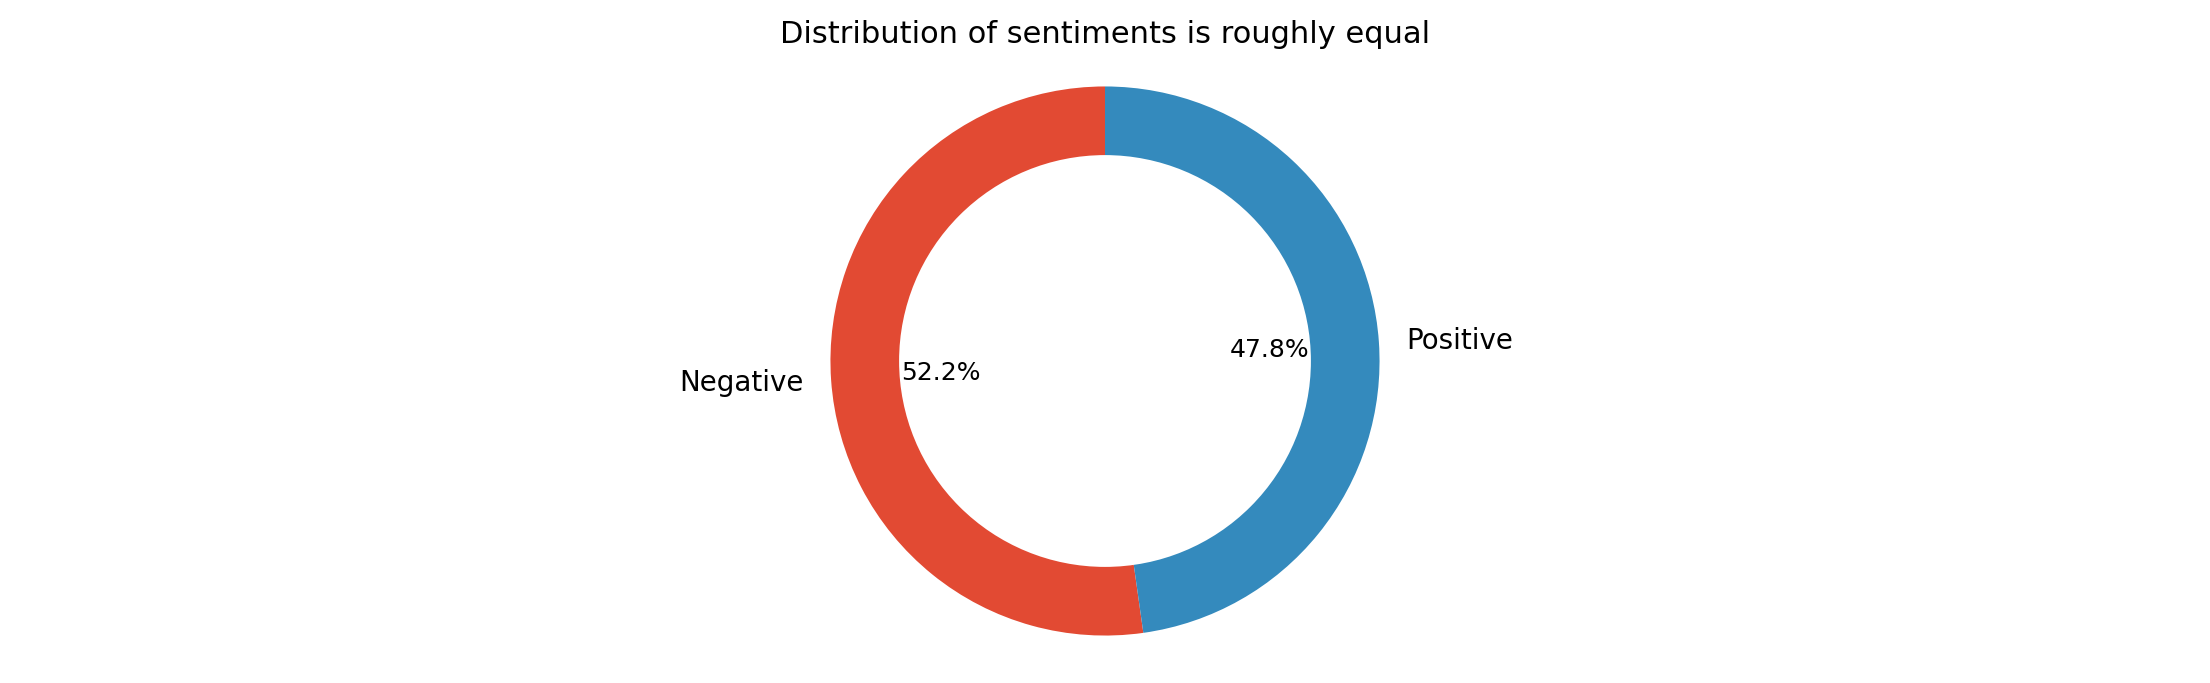

In [9]:
# make pie chart
fig, ax = plt.subplots(figsize=(14,4), dpi=200)
wedges, texts, autotexts = ax.pie(sentiment_df['proportion'],
                                  labels=sentiment_df['Sentiment'],
                                  autopct='%1.1f%%', startangle=90)

# set font size
for autotext in autotexts:
    autotext.set_fontsize(9)

# add circle to center
center_circle = plt.Circle((0,0), 0.75, fc='white')
fig.gca().add_artist(center_circle)
plt.axis('equal')
plt.title('Distribution of sentiments is roughly equal', size=11)
plt.show()

### **3.2 What are the most frequent words?**

In [10]:
# prepare stop words
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('indonesian'))
stop_words -= {'tidak'}
custom_stopwords = {'yang', 'aja', 'nya', 'sih', 'kok', 'oh', 'deh', 'ya',
                    'kan', 'nih'}
stop_words.update(custom_stopwords)

# define synonyms
synonym_dict = {
    'oke': 'ok', 'ga': 'tidak', 'tdk': 'tidak', 'g':'tidak', 'gak':'tidak',
    'kalo': 'kalau', 'jg': 'juga', 'dgn':'dengan', 'bgt':'banget', 'sy':'saya',
    'sdh':'sudah', 'yg':'yang', 'gk':'tidak', 'tp':'tapi', 'udh':'sudah',
    'jd':'jadi', 'd':'di', 'krn':'karena', 'utk':'untuk'
}

In [11]:
# function to normalize elongated words (e.g., sukaaaa -> suka)
def normalize_repeated_chars(word):
    return re.sub(r'(.)\1{2,}', r'\1', word)                            # replace >=3 chars with 1 char

# preprocess function
def tokenize_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '', text)                                 # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '', text)                      # remove URLs
        tokens = text.split()                                           # split into tokens
        tokens = [normalize_repeated_chars(word) for word in tokens]    # normalize elongated words
        tokens = [synonym_dict.get(word, word) for word in tokens]      # replace with synonym if it exists
        tokens = [word for word in tokens if word not in stop_words]    # remove stopwords
        return tokens
    return []                                                           # if not string, return an empty list

# apply preprocessing
df['tokens'] = df['CustomerReview'].apply(tokenize_text)

In [12]:
# check output
df.loc[:5, ['CustomerReview', 'tokens', 'Sentiment']]

CustomerReview  \
0  Alhamdulillah berfungsi dengan baik. Packaging...   
1  barang bagus dan respon cepat, harga bersaing ...   
2  barang bagus, berfungsi dengan baik, seler ram...   
3  bagus sesuai harapan penjual nya juga ramah. t...   
4  Barang Bagus, pengemasan Aman, dapat Berfungsi...   
5                       barang bagus, seller ramah..   

                                              tokens Sentiment  
0  [alhamdulillah, berfungsi, packaging, aman, re...  Positive  
1    [barang, bagus, respon, cepat, harga, bersaing]  Positive  
2  [barang, bagus, berfungsi, seler, ramah, pengi...  Positive  
3  [bagus, sesuai, harapan, penjual, ramah, trima...  Positive  
4       [barang, bagus, pengemasan, aman, berfungsi]  Positive  
5                     [barang, bagus, seller, ramah]  Positive

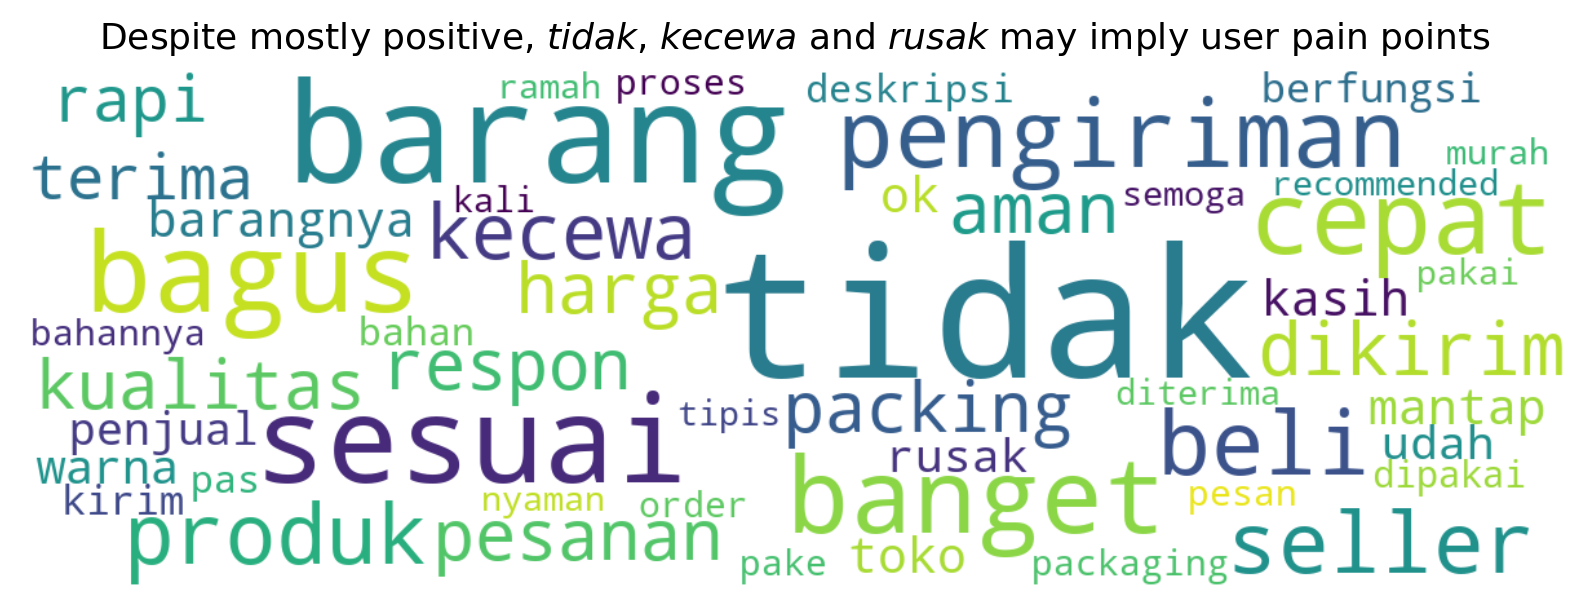

In [13]:
# prepare word counts
all_tokens = [word for tokens in df['tokens']
              for word in tokens if word not in stop_words]
word_counts = Counter(all_tokens)

# create word cloud
wordcloud = (WordCloud(width=1200, height=400, background_color='white',
                       max_words=50, prefer_horizontal=1.0)
             .generate_from_frequencies(dict(word_counts.most_common(50))))

plt.figure(figsize=(10, 5), dpi=200)
plt.imshow(wordcloud, interpolation='bilinear', cmap='tab20')
plt.title('Despite mostly positive, $tidak$, $kecewa$ and $rusak$ may imply user pain points', size=13, y=1.01)
plt.axis('off')
plt.show()

In [14]:
# preprocess function 
def clean_text(text):
    if isinstance(text, str):                                           # check if the input is a string
        text = text.lower()                                             # convert to lowercase
        text = re.sub(r'\d+', '', text)                                 # remove numbers
        text = re.sub(r'\W+', ' ', text)                                # remove punctuation
        text = re.sub(r'http\S+|www\S+', '', text)                      # remove URLs
        words = text.split()                                            # split into words
        words = [normalize_repeated_chars(word) for word in words]      # normalize elongated words
        words = [synonym_dict.get(word, word) for word in words]        # replace with synonym if it exists
        return ' '.join(words)                                          # rejoin words into a cleaned string
    return text                                                         # if not string, return as is

# apply the cleaning
df['CleanReview'] = df['CustomerReview'].apply(clean_text)

## **4 Predictive Modeling**

### **4.1 Introduction**

### **4.2 Data Preparation**

In [17]:
# 1. Prepare features and labels
X = df['CleanReview']  # Feature: Cleaned text
y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)    # Target: Sentiment labels

# 2. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer()  # Limit to top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Train the model (e.g., Logistic Regression)
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# 5. Make predictions
y_pred = model.predict(X_test_tfidf)

# 6. Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9481000926784059
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       562
           1       0.98      0.91      0.94       517

    accuracy                           0.95      1079
   macro avg       0.95      0.95      0.95      1079
weighted avg       0.95      0.95      0.95      1079



In [18]:
# Encode Sentiment
df['SentimentEnc'] = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

# Prepare features and labels
X = df['CleanReview']
y = df['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
print(f'The X_train consists of {X_train_tfidf.shape[0]} rows and {X_train_tfidf.shape[1]} columns')
print(f'The y_train consists of {y_train.shape[0]} rows')
print(f'X_test consists of {X_test_tfidf.shape[0]} rows and {X_test_tfidf.shape[1]} columns')
print(f'The y_test consists of {y_test.shape[0]} rows')

The X_train consists of 4314 rows and 7180 columns
The y_train consists of 4314 rows
X_test consists of 1079 rows and 7180 columns
The y_test consists of 1079 rows


In [20]:
# Vectorize text once
vectorizer = TfidfVectorizer()  # Reduced max_features for speed
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [21]:
# specify models
classifiers = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Support Vector Machine', SVC(probability=True)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('CatBoost', CatBoostClassifier(verbose=0, random_state=42))
]

# specify scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='micro', zero_division=0),
    'recall': make_scorer(recall_score, average='micro', zero_division=0),
    'f1': make_scorer(f1_score, average='micro', zero_division=0),
    'hammingloss': make_scorer(hamming_loss)
}

# specify stratified k-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### **4.3 Model Comparison**

In [22]:
# Evaluate each model
results = []
for name, model in classifiers:
    scores = {}
    start_time = time.time()
    for metric_name, scorer in scoring.items():
        cv_results = cross_validate(model, X_train_tfidf, y_train, cv=skf,
                                    scoring=scorer, n_jobs=-1)
        scores[f"{metric_name}"] = np.mean(cv_results['test_score'])
        scores[f"{metric_name}_sd"] = np.std(cv_results['test_score'])
    end_time = time.time()
    training_time = end_time - start_time
    scores['training_time'] = training_time
    results.append((name, scores))

In [23]:
# Show results
results_df = pd.DataFrame(results, columns=['Model', 'Scores'])
scores_df = results_df['Scores'].apply(pd.Series)
results_df = pd.concat([results_df[['Model']], scores_df], axis=1).round(3)
results_df = results_df.set_index('Model')
results_df

accuracy  accuracy_sd  precision  precision_sd  \
Model                                                                    
Logistic Regression        0.940        0.005      0.940         0.005   
K-Nearest Neighbors        0.890        0.006      0.890         0.006   
Support Vector Machine     0.949        0.006      0.949         0.006   
Decision Tree              0.862        0.005      0.862         0.005   
Random Forest              0.930        0.010      0.930         0.010   
Gradient Boosting          0.900        0.005      0.900         0.005   
AdaBoost                   0.895        0.004      0.895         0.004   
XGBoost                    0.931        0.007      0.931         0.007   
CatBoost                   0.933        0.005      0.933         0.005   

                        recall  recall_sd     f1  f1_sd  hammingloss  \
Model                                                                  
Logistic Regression      0.940      0.005  0.940  0.005        0.060   
K-Nearest Neighbors      0.890      0.006  0.890  0.006        0.110   
Support Vector Machine   0.949      0.006  0.949  0.006        0.051   
Decision Tree            0.862      0.005  0.862  0.005        0.138   
Random Forest            0.930      0.010  0.930  0.010        0.070   
Gradient Boosting        0.900      0.005  0.900  0.005        0.100   
AdaBoost                 0.895      0.004  0.895  0.004        0.105   
XGBoost                  0.931      0.007  0.931  0.007        0.069   
CatBoost                 0.933      0.005  0.933  0.005        0.067   

                        hammingloss_sd  training_time  
Model                                                  
Logistic Regression              0.005         11.309  
K-Nearest Neighbors              0.006          6.998  
Support Vector Machine           0.006         71.199  
Decision Tree                    0.005          5.369  
Random Forest                    0.010         69.331  
Gradient Boosting                0.005         73.426  
AdaBoost                         0.004         24.339  
XGBoost                          0.007         21.269  
CatBoost                         0.005        758.014

In [24]:
# Get model names
best_model_name = results_df['f1'].idxmax()
worst_model_name = results_df['f1'].idxmin()
best_f1_score = results_df.loc[best_model_name, 'f1']
worst_f1_score = results_df.loc[worst_model_name, 'f1']
best_f1_std = results_df.loc[best_model_name, 'f1_sd']
worst_f1_std = results_df.loc[worst_model_name, 'f1_sd']

# Print best & worst model
print(f'Best model: {best_model_name}, F1 Score: {best_f1_score:.3f}, Standard Deviation: {best_f1_std:.3f}')
print(f'Worst model: {worst_model_name}, F1 Score: {worst_f1_score:.3f}, Standard Deviation: {worst_f1_std:.3f}')

Best model: Support Vector Machine, F1 Score: 0.949, Standard Deviation: 0.006
Worst model: Decision Tree, F1 Score: 0.862, Standard Deviation: 0.005


### **4.4 Model Development**

In [25]:
# retrieve best model name
best_model_ori = dict(classifiers)[best_model_name]

# create pipeline with best model
best_pipeline = Pipeline(steps=[
    ('vectorizer', vectorizer),
    ('classifier', best_model_ori)
])

# fit model on training data
best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', SVC(probability=True))])

In [26]:
# Step 1: Make predictions on the test data (use X_test, not X_test_tfidf)
predictions = best_pipeline.predict(X_test)

# Step 2: Evaluate the model
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='micro', zero_division=0)
recall = recall_score(y_test, predictions, average='micro', zero_division=0)
f1 = f1_score(y_test, predictions, average='micro', zero_division=0)
hamming_loss_value = hamming_loss(y_test, predictions)

# Step 4: Create df to store the metrics
test_ori = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Hamming Loss'],
    'Score': [accuracy, precision, recall, f1, hamming_loss_value]
})

# Display the metrics
display(test_ori)

Metric     Score
0      Accuracy  0.958295
1     Precision  0.958295
2        Recall  0.958295
3      F1 Score  0.958295
4  Hamming Loss  0.041705

In [27]:
# Step 3: Print metrics
print('Classification report:')
print(classification_report(y_test, predictions, target_names=['Negative', 'Positive']))

Classification report:
              precision    recall  f1-score   support

    Negative       0.94      0.98      0.96       562
    Positive       0.98      0.93      0.96       517

    accuracy                           0.96      1079
   macro avg       0.96      0.96      0.96      1079
weighted avg       0.96      0.96      0.96      1079



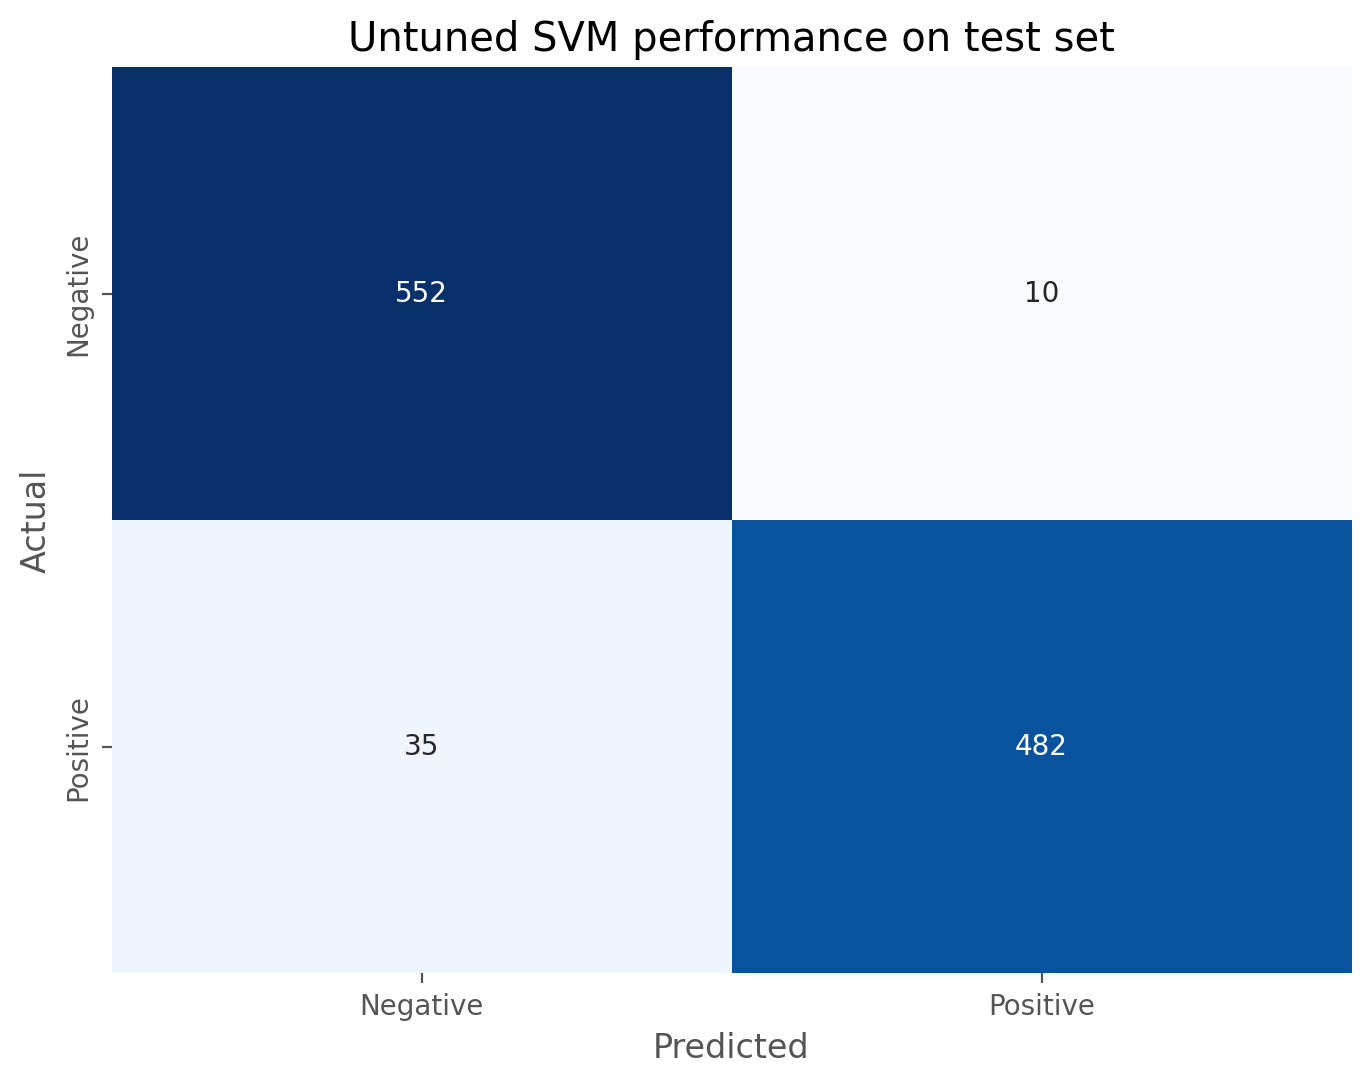

In [28]:
# get confusion matrix
y_pred_untuned = best_pipeline.predict(X_test)
cm = confusion_matrix(y_test, y_pred_untuned)

# display confusion matrix
plt.figure(figsize=(8,6), dpi=200)
ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', cbar=False)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Untuned SVM performance on test set')
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.show()

### **4.5 Model Tuning**

In [29]:
# define parameter grid
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],         # regularization parameter
    'classifier__kernel': ['linear', 'rbf'],    # type of kernel
    'classifier__gamma': ['scale', 'auto']      # kernel coefficient
}

# set up GridSearchCV for model tuning
grid_search = GridSearchCV(estimator=best_pipeline,
                           param_grid=param_grid,
                           scoring='f1',
                           cv=5,
                           n_jobs=-1,
                           verbose=0)          

In [30]:
# fit GridSearchCV
grid_search.fit(X_train, y_train)

# get best parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.3f}")

Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear'}
Best Cross-Validation Score: 0.949


In [31]:
# get best model from grid search
best_model = grid_search.best_estimator_

# make predictions on test set
predictions = best_model.predict(X_test)

In [32]:
# compute performance scores
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='micro', zero_division=0)
recall = recall_score(y_test, predictions, average='micro', zero_division=0)
f1 = f1_score(y_test, predictions, average='micro', zero_division=0)
hamming_loss_value = hamming_loss(y_test, predictions)

# create df to store test outputs
test_tuned = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Hamming Loss'],
    'Score': [accuracy, precision, recall, f1, hamming_loss_value]
})

# display output
display(test_tuned)

Metric     Score
0      Accuracy  0.965709
1     Precision  0.965709
2        Recall  0.965709
3      F1 Score  0.965709
4  Hamming Loss  0.034291

In [33]:
print('Classification report (tuned model):')
print(classification_report(y_test, predictions, target_names=['Negative', 'Positive']))

Classification report (tuned model):
              precision    recall  f1-score   support

    Negative       0.95      0.98      0.97       562
    Positive       0.98      0.95      0.96       517

    accuracy                           0.97      1079
   macro avg       0.97      0.96      0.97      1079
weighted avg       0.97      0.97      0.97      1079



In [34]:
# Predict on the test set for both models
y_pred_test_ori = best_pipeline.predict(X_test)
y_pred_test_tuned = best_model.predict(X_test)

# Compute confusion matrices
cm_ori = confusion_matrix(y_test, y_pred_test_ori)
cm_tuned = confusion_matrix(y_test, y_pred_test_tuned)

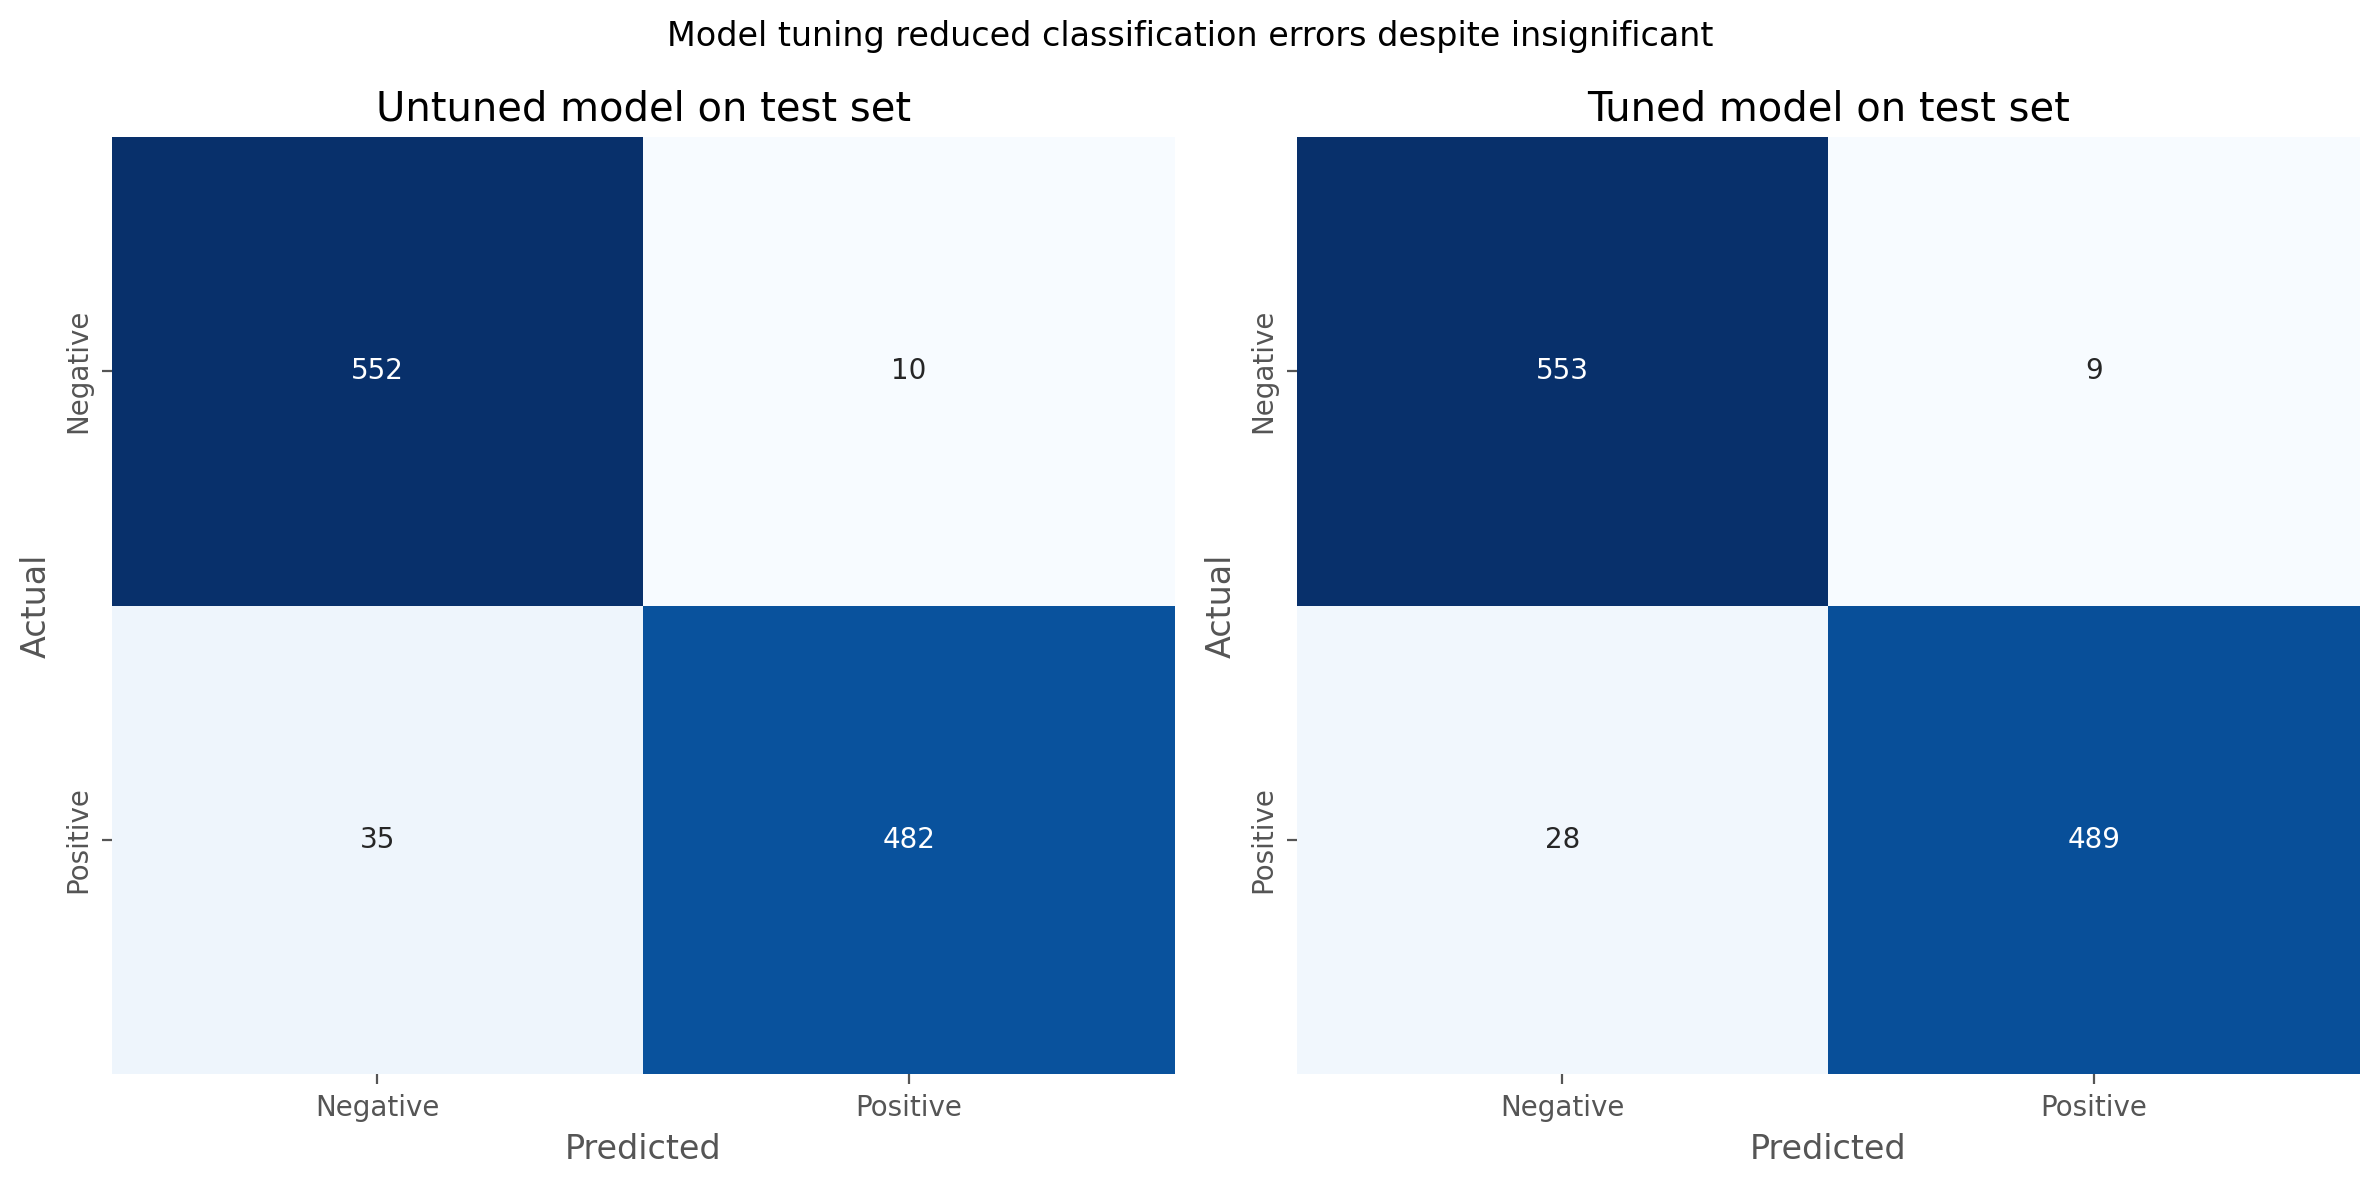

In [35]:
# create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

# plot confusion matrix for untuned model
sns.heatmap(cm_ori, annot=True, fmt='g', ax=axs[0], cmap='Blues', cbar=False)
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Untuned model on test set')
axs[0].set_xticklabels(['Negative', 'Positive'])
axs[0].set_yticklabels(['Negative', 'Positive'])

# plot confusion matrix for tuned model
sns.heatmap(cm_tuned, annot=True, fmt='g', ax=axs[1], cmap='Blues', cbar=False)
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Tuned model on test set')
axs[1].set_xticklabels(['Negative', 'Positive'])
axs[1].set_yticklabels(['Negative', 'Positive'])

plt.suptitle('Model tuning reduced classification errors despite insignificant')
plt.tight_layout()
plt.show()

## **5 Model Explaination (XAI)**

### **ROC-AUC Curve**

In [36]:
y_prob_test = best_model.predict_proba(X_test)[:, 1]

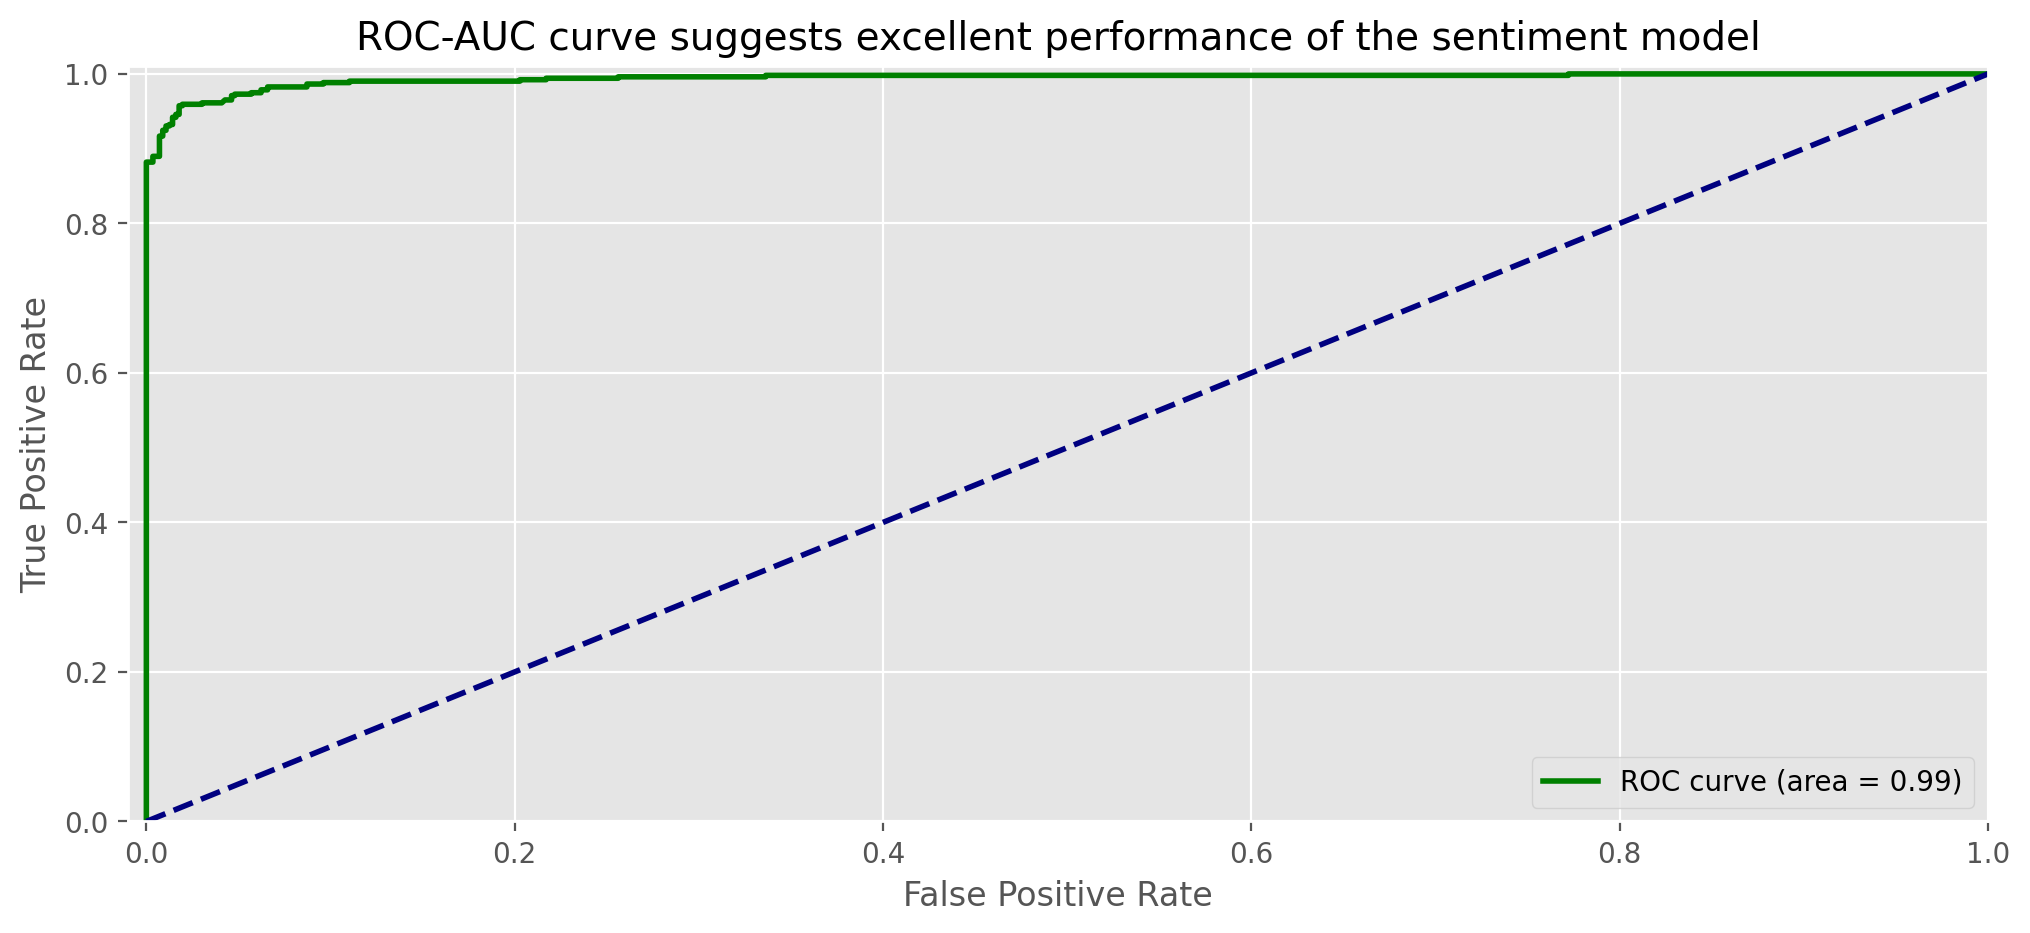

In [37]:
# plot ROC-AUC curve
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5), dpi=200)
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve suggests excellent performance of the sentiment model', fontsize=14)
plt.legend(loc="lower right")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.01)
plt.show()

### **Precision-Recall Curve**

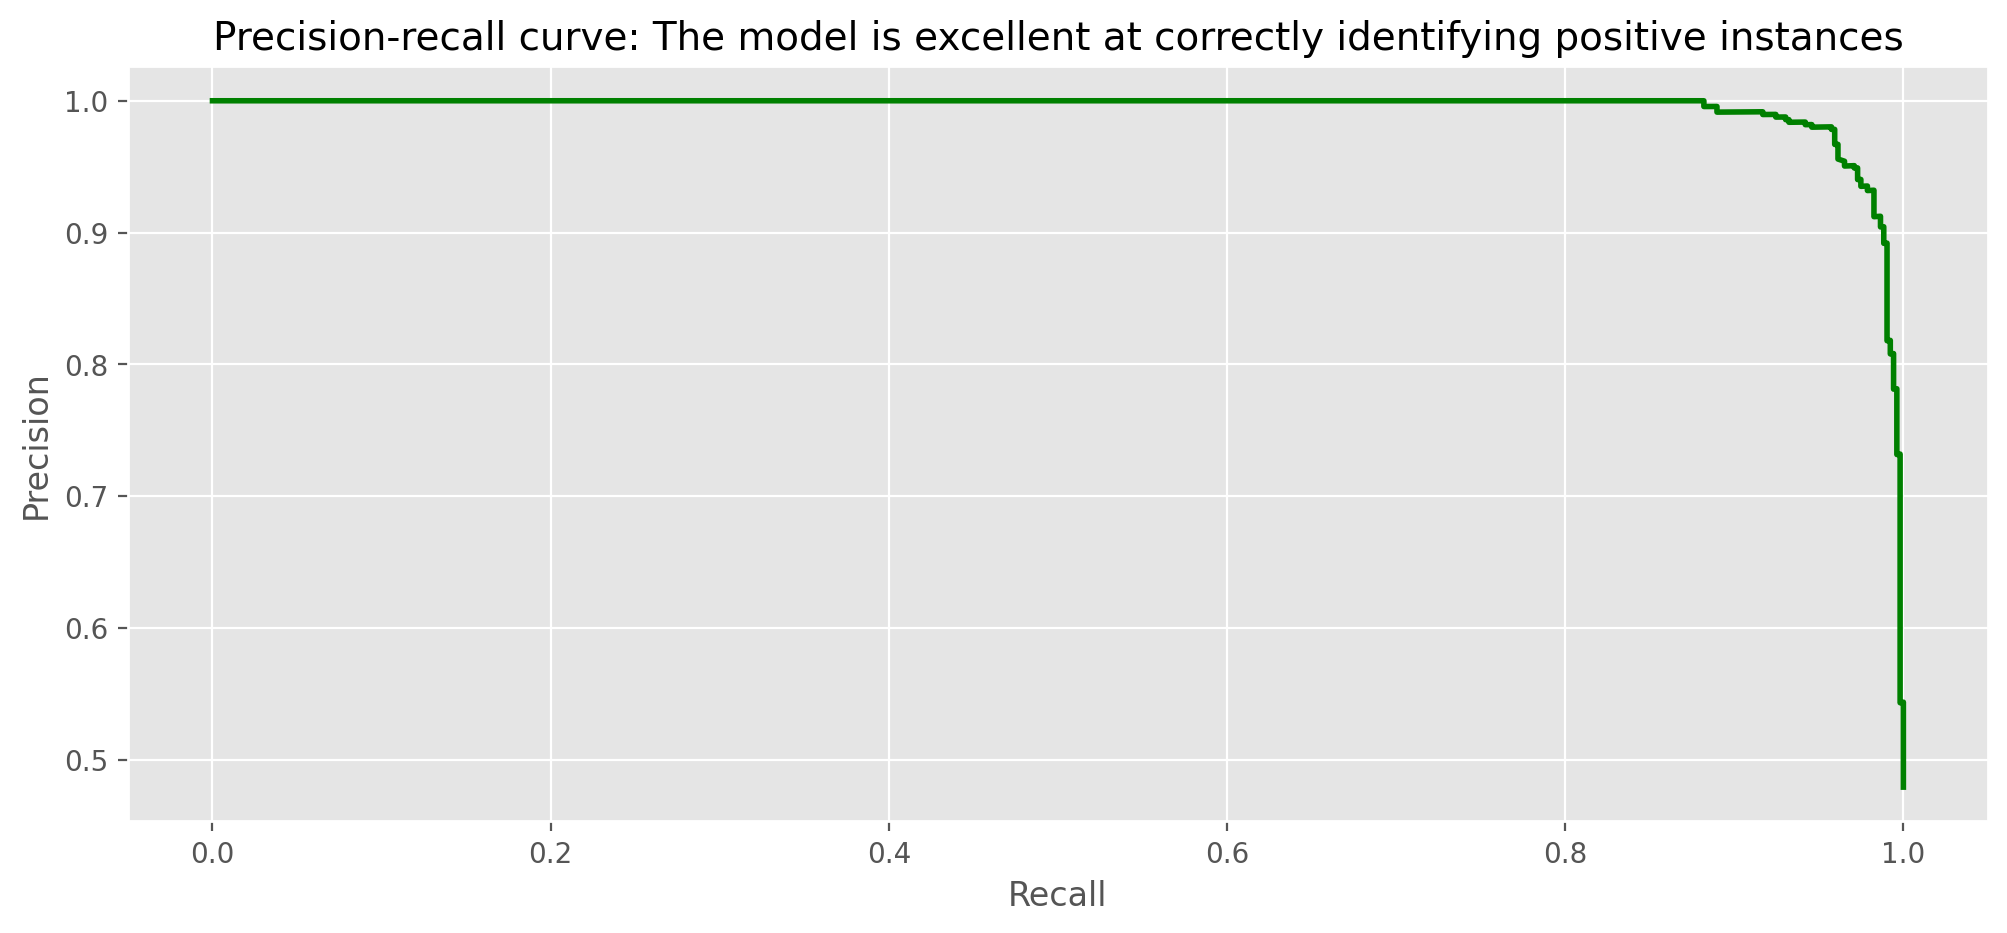

In [38]:
# plot PR curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_test)

plt.figure(figsize=(12, 5), dpi=200)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve: The model is excellent at correctly identifying positive instances', size=14)
plt.show()

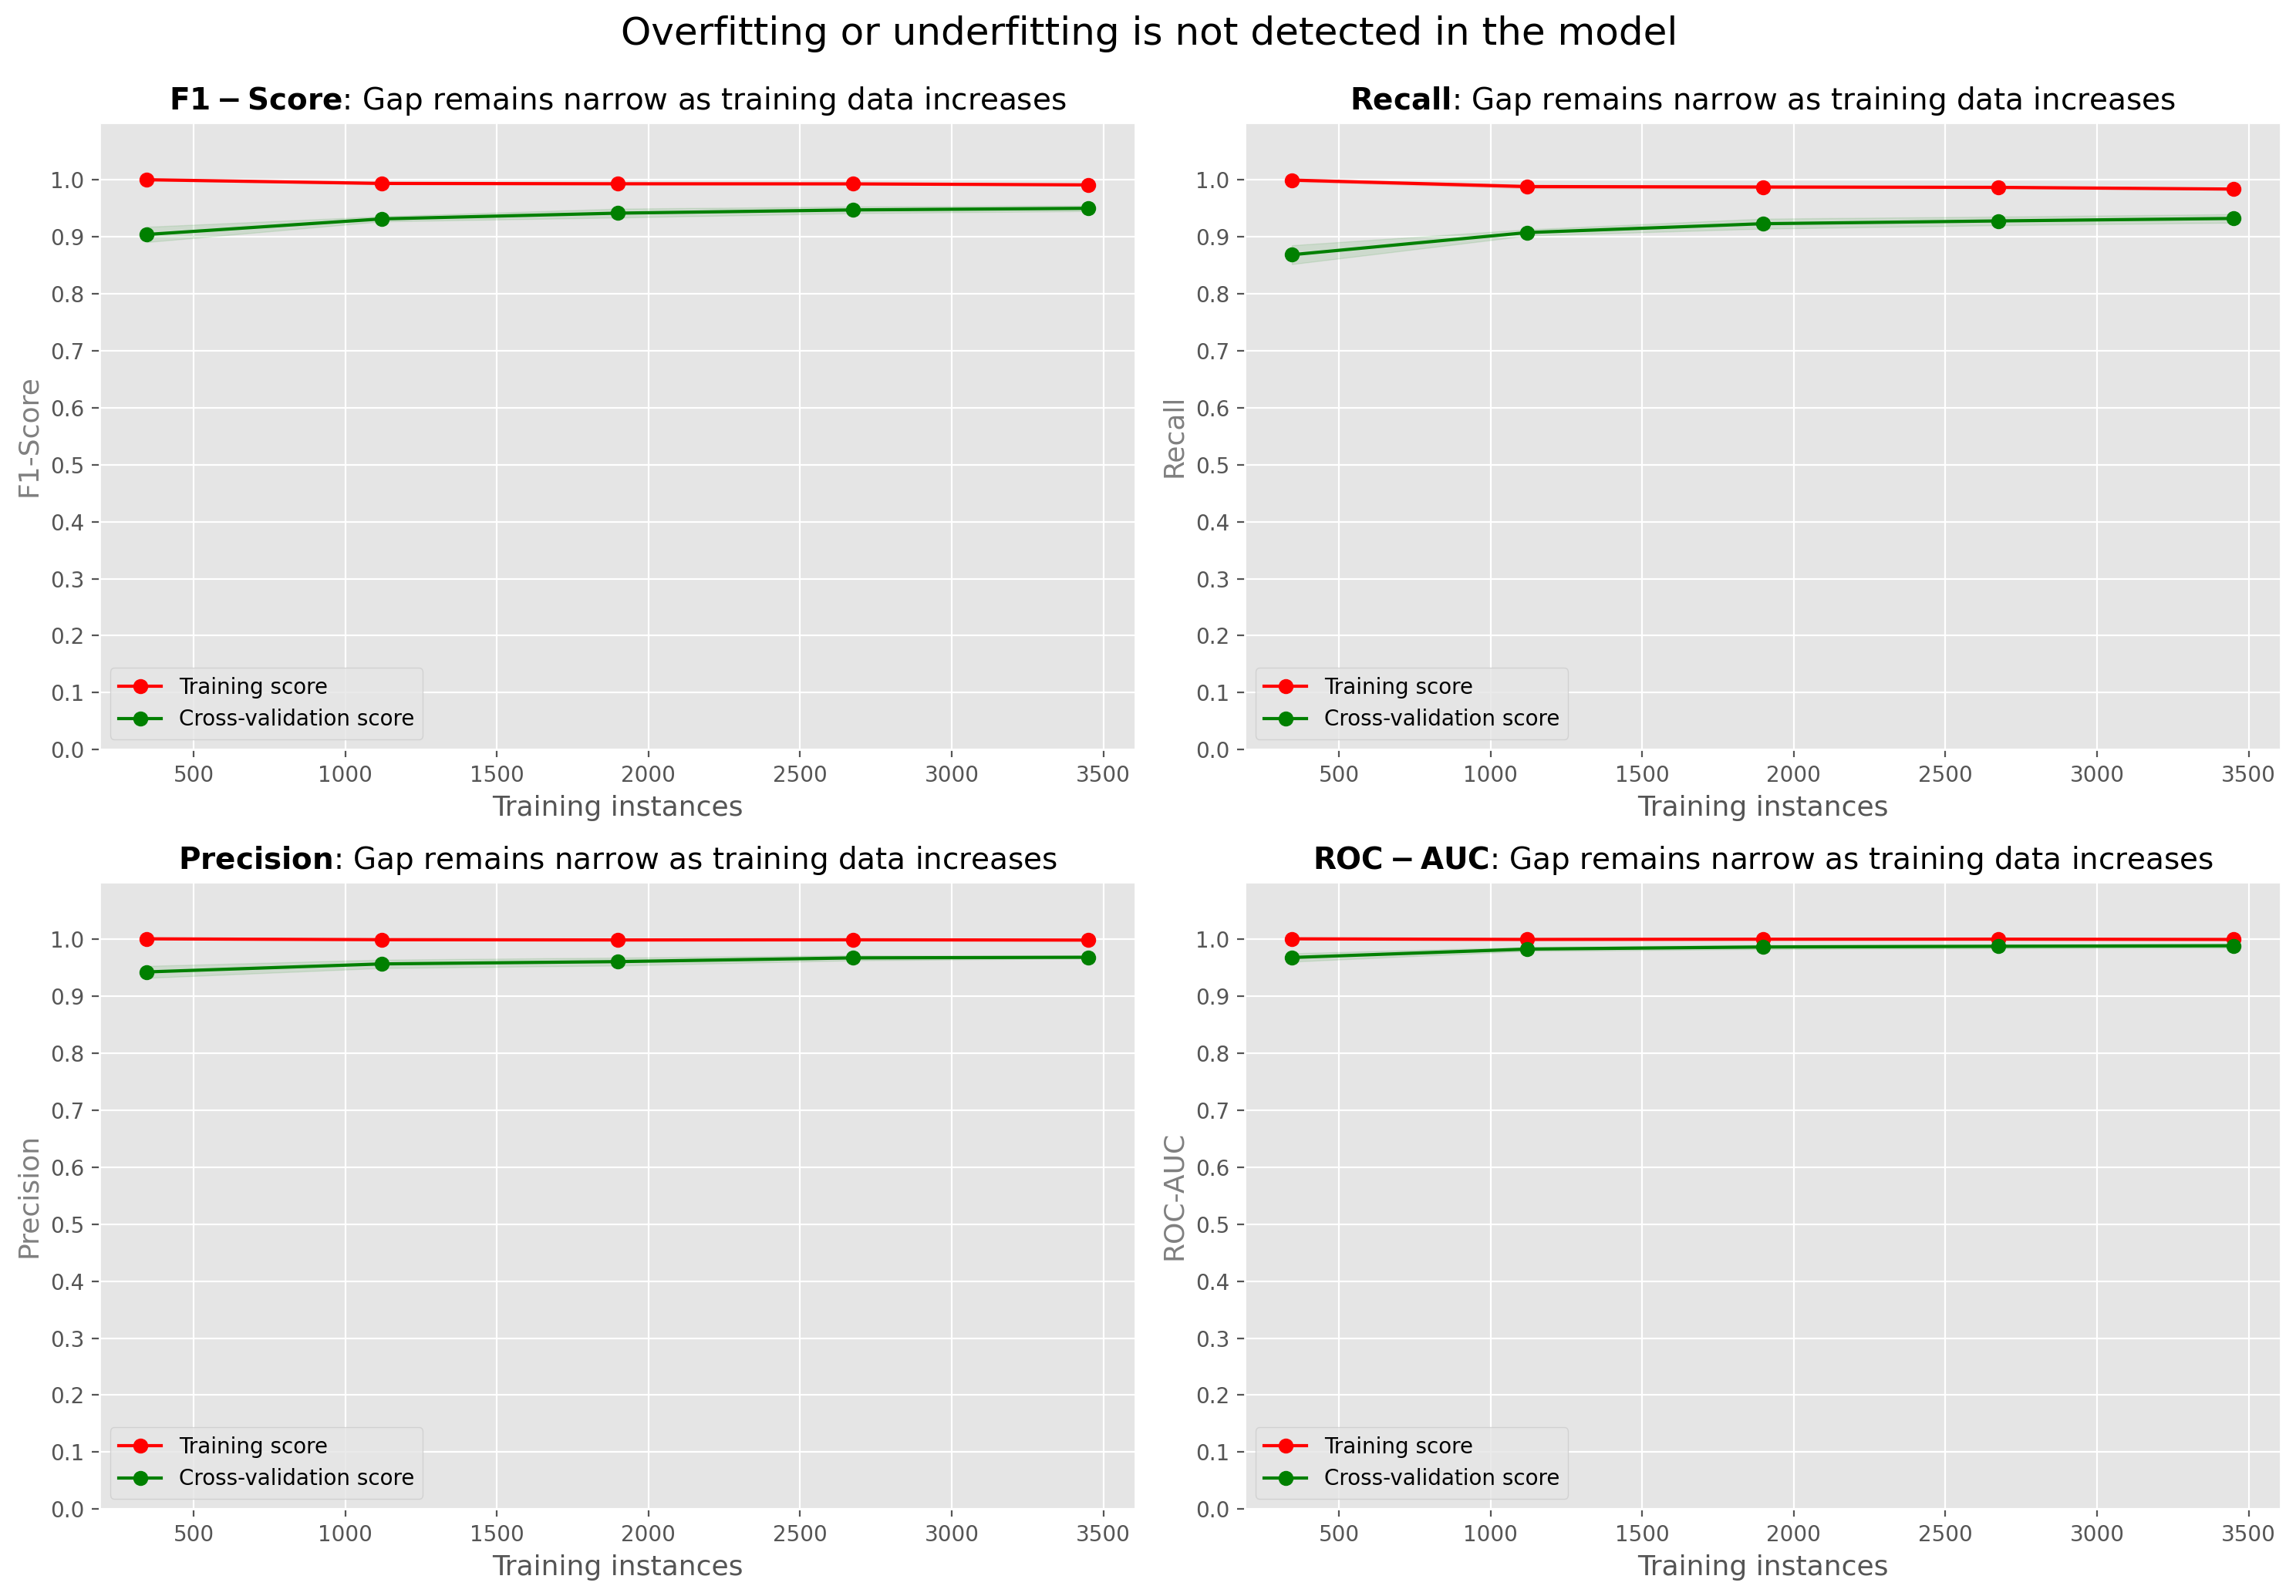

In [39]:
# define the metrics
metrics = {
    'F1-Score': 'f1',
    'Recall': 'recall',
    'Precision': 'precision',
    'ROC-AUC': 'roc_auc'
}

# init the figure and axis array
fig, axes = plt.subplots(2, 2, figsize=(15, 10), dpi=200)
axes = axes.ravel()  

# loop through each metric
for i, (metric_name, metric) in enumerate(metrics.items()):
    train_sizes, train_scores, test_scores = learning_curve(
        best_model, X_train, y_train, cv=5, scoring=metric, n_jobs=-1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes[i].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    axes[i].set_xlabel('Training instances', size=13)
    axes[i].set_ylabel(metric_name, size=13, color='grey')
    axes[i].set_title(rf'$\bf{{{metric_name}}}$: Gap remains narrow as training data increases', size=14)
    axes[i].legend(loc="best")
    axes[i].set_ylim(0, 1.1)
    axes[i].set_yticks(np.arange(0, 1.1, 0.1))

plt.tight_layout()
plt.suptitle('Overfitting or underfitting is not detected in the model', 
             y=1.03, size=18)
plt.show()

In [40]:
# ROC-AUC (for adding details)
learning_curve_data = pd.DataFrame({
    'training_mean': train_scores_mean,
    'training_sd': train_scores_std,
    'testing_mean': test_scores_mean,
    'testing_sd': test_scores_std
}).round(3)
learning_curve_data['mean_diff'] = learning_curve_data['training_mean'] - learning_curve_data['testing_mean']
display(learning_curve_data)

training_mean  training_sd  testing_mean  testing_sd  mean_diff
0          1.000          0.0         0.967       0.007      0.033
1          0.999          0.0         0.982       0.003      0.017
2          0.999          0.0         0.986       0.004      0.013
3          0.999          0.0         0.987       0.004      0.012
4          0.999          0.0         0.988       0.004      0.011

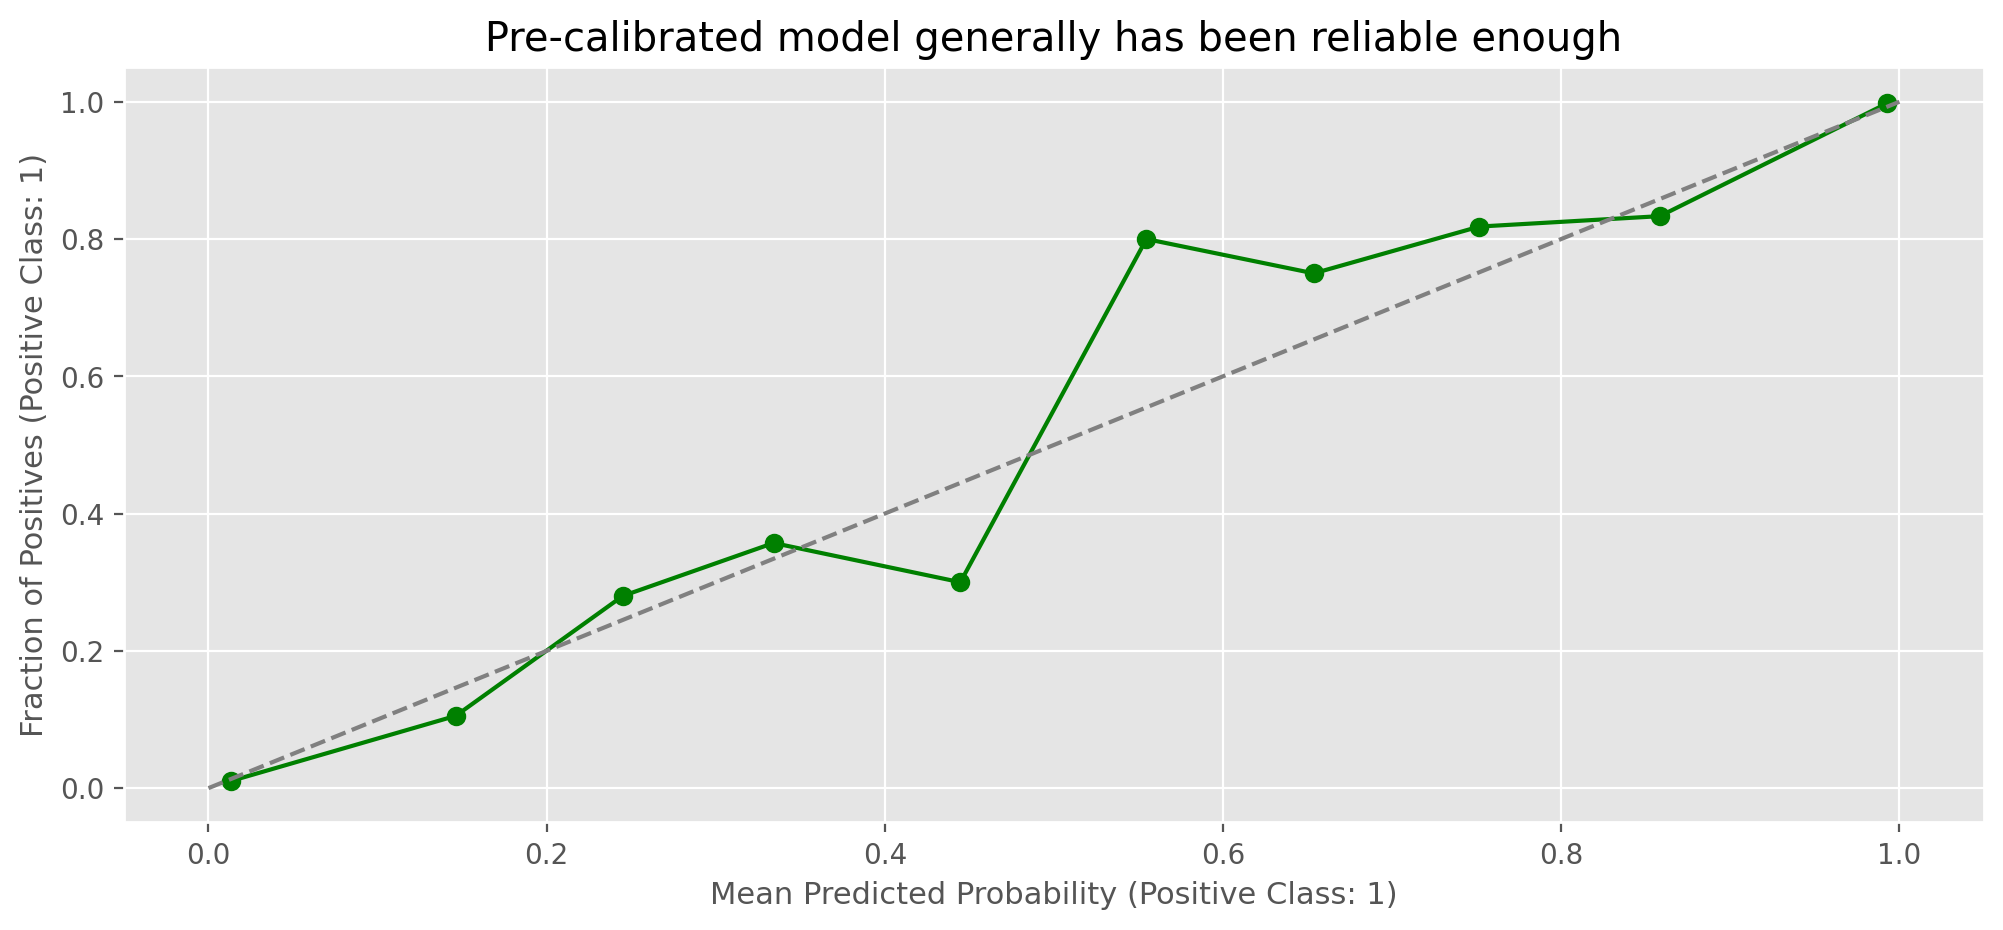

In [41]:
# predict probabilities on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# plot Reliability Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(12, 5), dpi=200)
plt.plot(prob_pred, prob_true, marker='o', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)', size=11)
plt.ylabel('Fraction of Positives (Positive Class: 1)', size=11)
plt.title('Pre-calibrated model generally has been reliable enough')
plt.show()

In [42]:
# get reliability in numbers
precalibration_df = pd.DataFrame({
    'Predicted Probability': prob_pred,
    'Fraction of Positives': prob_true
})

precalibration_df['Difference'] = precalibration_df['Predicted Probability'] - precalibration_df['Fraction of Positives']
print('Pre-calibration data:')
precalibration_df.round(2)

Pre-calibration data:


Predicted Probability  Fraction of Positives  Difference
0                   0.01                   0.01        0.00
1                   0.15                   0.11        0.04
2                   0.25                   0.28       -0.03
3                   0.33                   0.36       -0.02
4                   0.44                   0.30        0.14
5                   0.55                   0.80       -0.25
6                   0.65                   0.75       -0.10
7                   0.75                   0.82       -0.07
8                   0.86                   0.83        0.03
9                   0.99                   1.00       -0.00

In [43]:
# compute brier score
y_true = y_test
y_prob_test = best_model.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_true, y_prob_test)
print(f"Brier score of pre-calibrated model: {brier_score:.4f}")

Brier score of pre-calibrated model: 0.0258


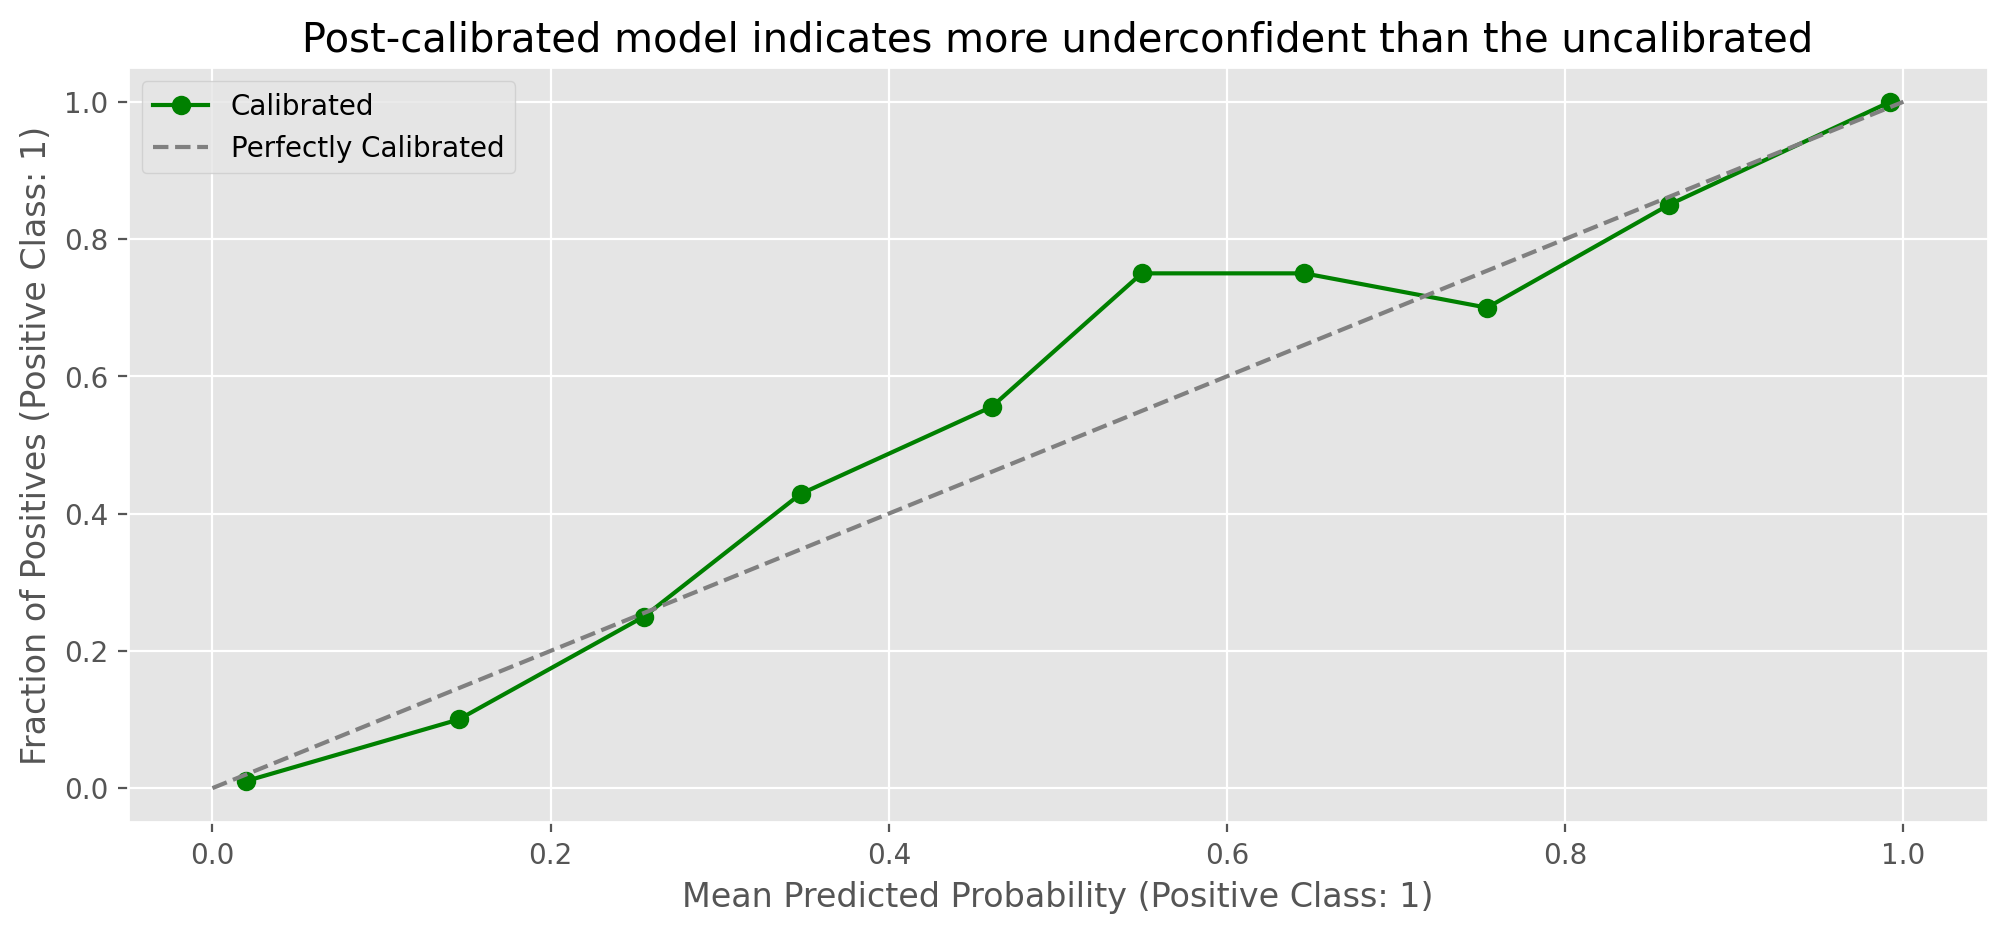

In [44]:
calibrated_clf = CalibratedClassifierCV(estimator=best_model, method='isotonic')
calibrated_clf.fit(X_train, y_train)
y_pred_proba = calibrated_clf.predict_proba(X_test)[:, 1]

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)

# plot the calibration curve
plt.figure(figsize=(12, 5), dpi=200)
plt.plot(prob_pred, prob_true, marker='o', color='green', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability (Positive Class: 1)')
plt.ylabel('Fraction of Positives (Positive Class: 1)')
plt.title('Post-calibrated model indicates more underconfident than the uncalibrated')
plt.legend(loc='best')
plt.show()

In [45]:
postcalibration_df = pd.DataFrame({
    'Predicted Probability': prob_pred,
    'Fraction of Positives': prob_true
})
print('Post-calibration data:')
postcalibration_df['Difference'] = postcalibration_df['Predicted Probability'] - postcalibration_df['Fraction of Positives']
postcalibration_df.round(2)

Post-calibration data:


Predicted Probability  Fraction of Positives  Difference
0                   0.02                   0.01        0.01
1                   0.15                   0.10        0.05
2                   0.26                   0.25        0.01
3                   0.35                   0.43       -0.08
4                   0.46                   0.56       -0.09
5                   0.55                   0.75       -0.20
6                   0.65                   0.75       -0.10
7                   0.75                   0.70        0.05
8                   0.86                   0.85        0.01
9                   0.99                   1.00       -0.01

In [46]:
# compute brier score
y_prob_test = calibrated_clf.predict_proba(X_test)[:, 1]
brier_score = brier_score_loss(y_true, y_prob_test)
print(f"Brier score of pre-calibrated model: {brier_score:.4f}")

Brier score of pre-calibrated model: 0.0260


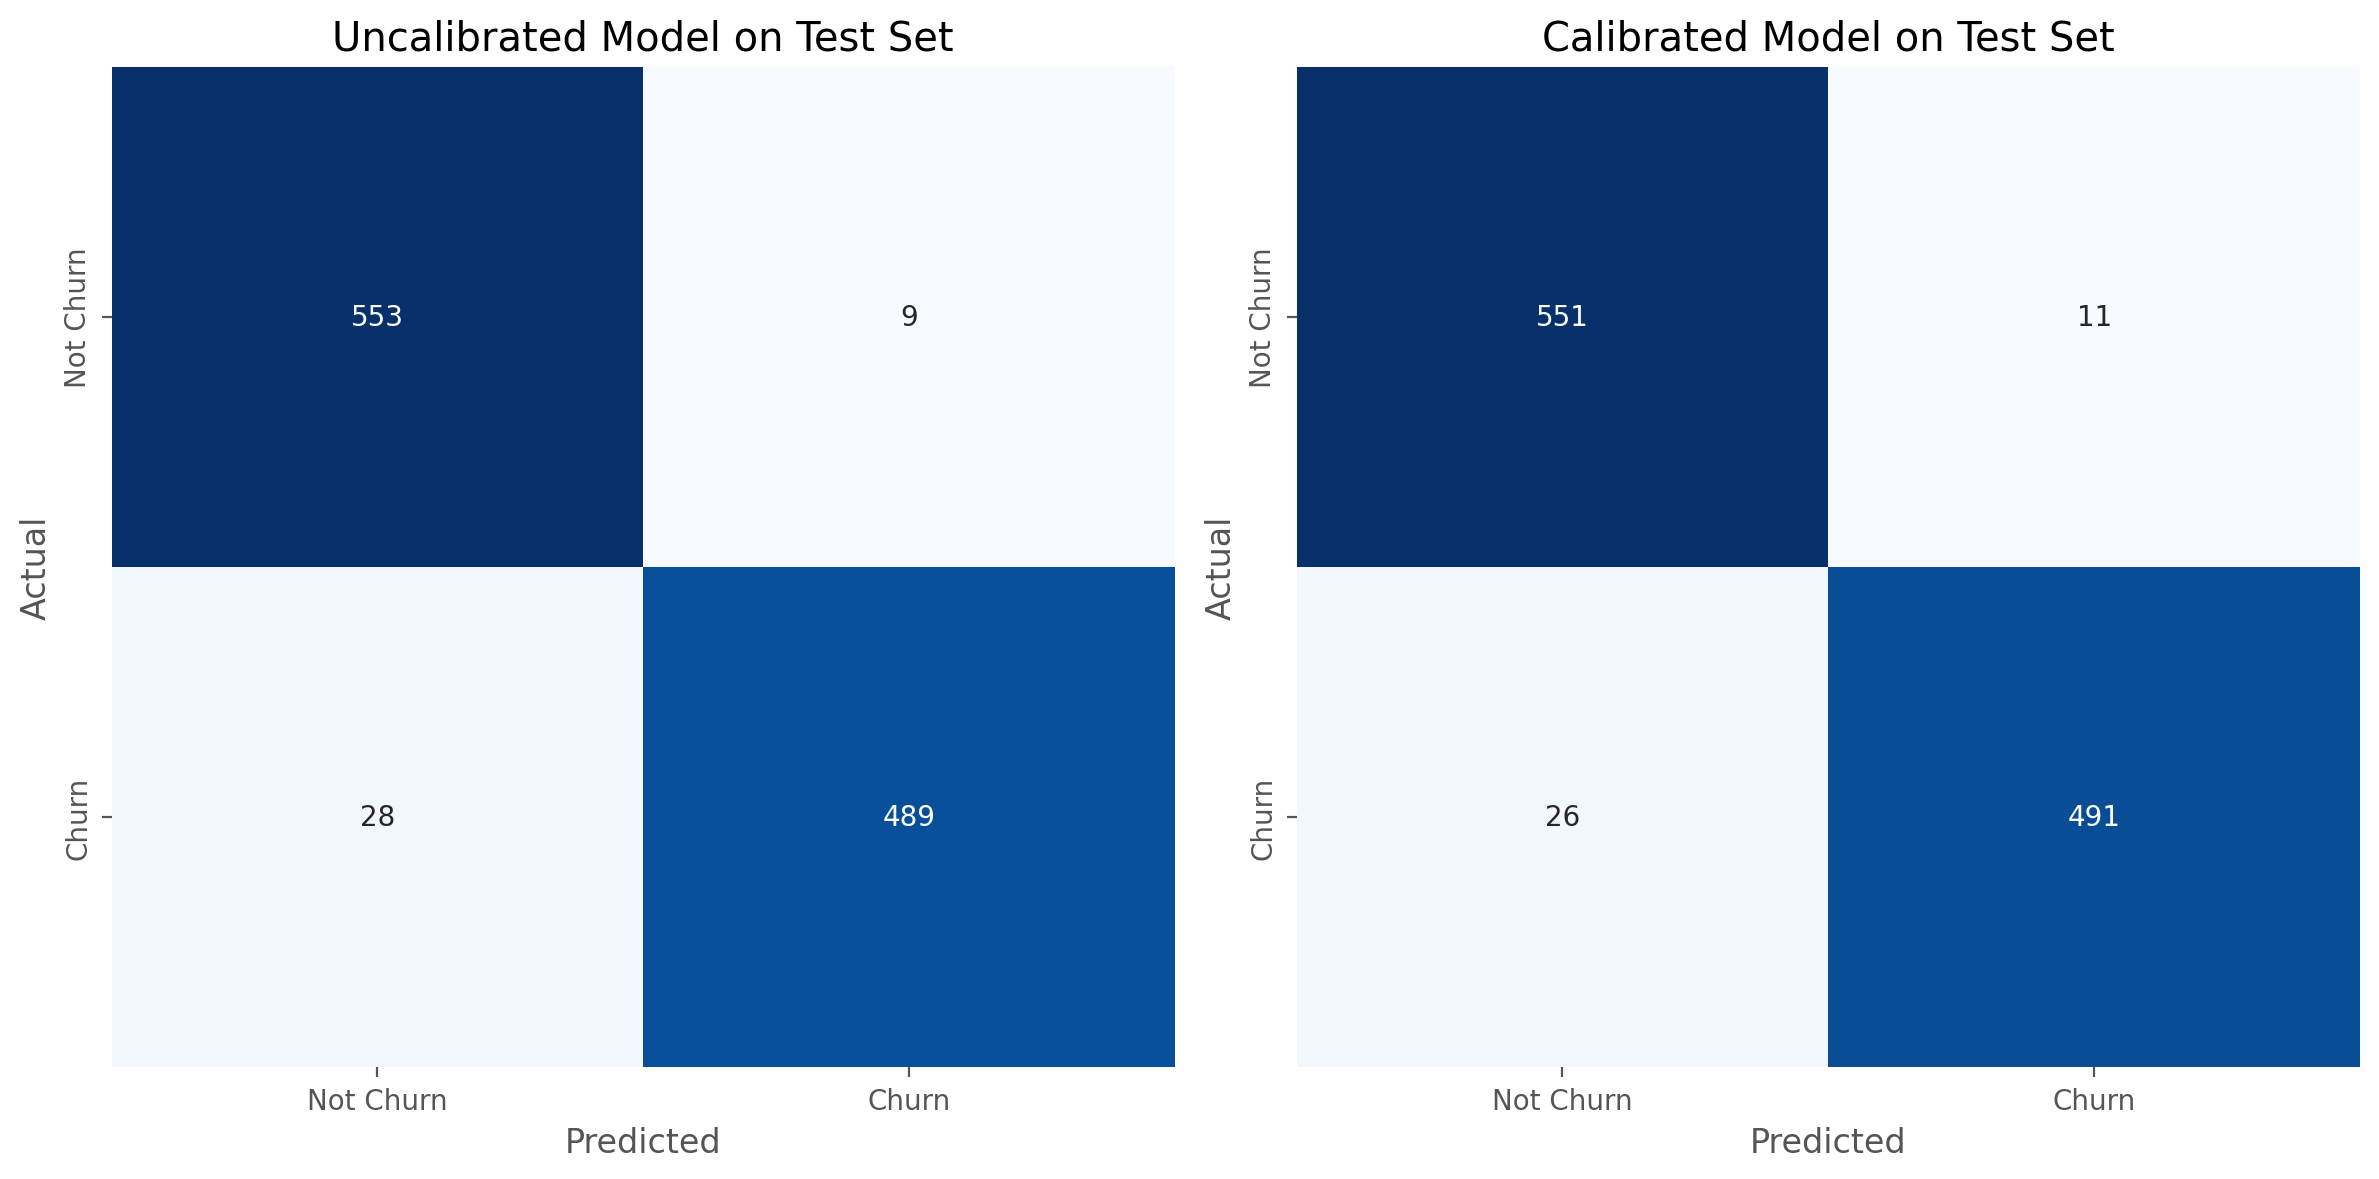

In [47]:
# Predict on the test set for both models
y_pred_test_uncal = best_model.predict(X_test)
y_pred_test_cal = calibrated_clf.predict(X_test)

# Compute confusion matrices
cm_uncal = confusion_matrix(y_test, y_pred_test_uncal)
cm_cal = confusion_matrix(y_test, y_pred_test_cal)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=200)

# Plot confusion matrix for uncalibrated model
sns.heatmap(cm_uncal, annot=True, fmt='g', ax=axs[0], cmap='Blues', cbar=False)
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')
axs[0].set_title('Uncalibrated Model on Test Set')
axs[0].set_xticklabels(['Not Churn', 'Churn'])
axs[0].set_yticklabels(['Not Churn', 'Churn'])

# Plot confusion matrix for calibrated model
sns.heatmap(cm_cal, annot=True, fmt='g', ax=axs[1], cmap='Blues', cbar=False)
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')
axs[1].set_title('Calibrated Model on Test Set')
axs[1].set_xticklabels(['Not Churn', 'Churn'])
axs[1].set_yticklabels(['Not Churn', 'Churn'])

# Adjust layout
plt.tight_layout()
plt.show()

### **5.1 How Support Vector Machine Works**

### **5.2 Global Explanation: Feature Importance**

In [48]:
# get coefficients of linear SVM
coefficients = best_model.named_steps['classifier'].coef_.toarray().flatten()  # convert to dense

# get feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# take top positive and negative coefficients
top_positive_coefficients = np.argsort(coefficients)[-10:]  # top 10 positive
top_negative_coefficients = np.argsort(coefficients)[:10]   # top 10 negative

# Prepare data for visualization
top_features_idx = np.concatenate([top_negative_coefficients, top_positive_coefficients])
top_features = feature_names[top_features_idx]
top_coefficients = coefficients[top_features_idx]
top_features_df = pd.DataFrame({'Feature': top_features, 'Coefficient': top_coefficients})

# specify colors
top_features_df['Color'] = np.where(top_features_df['Coefficient'] > 0, 'blue', 'red')

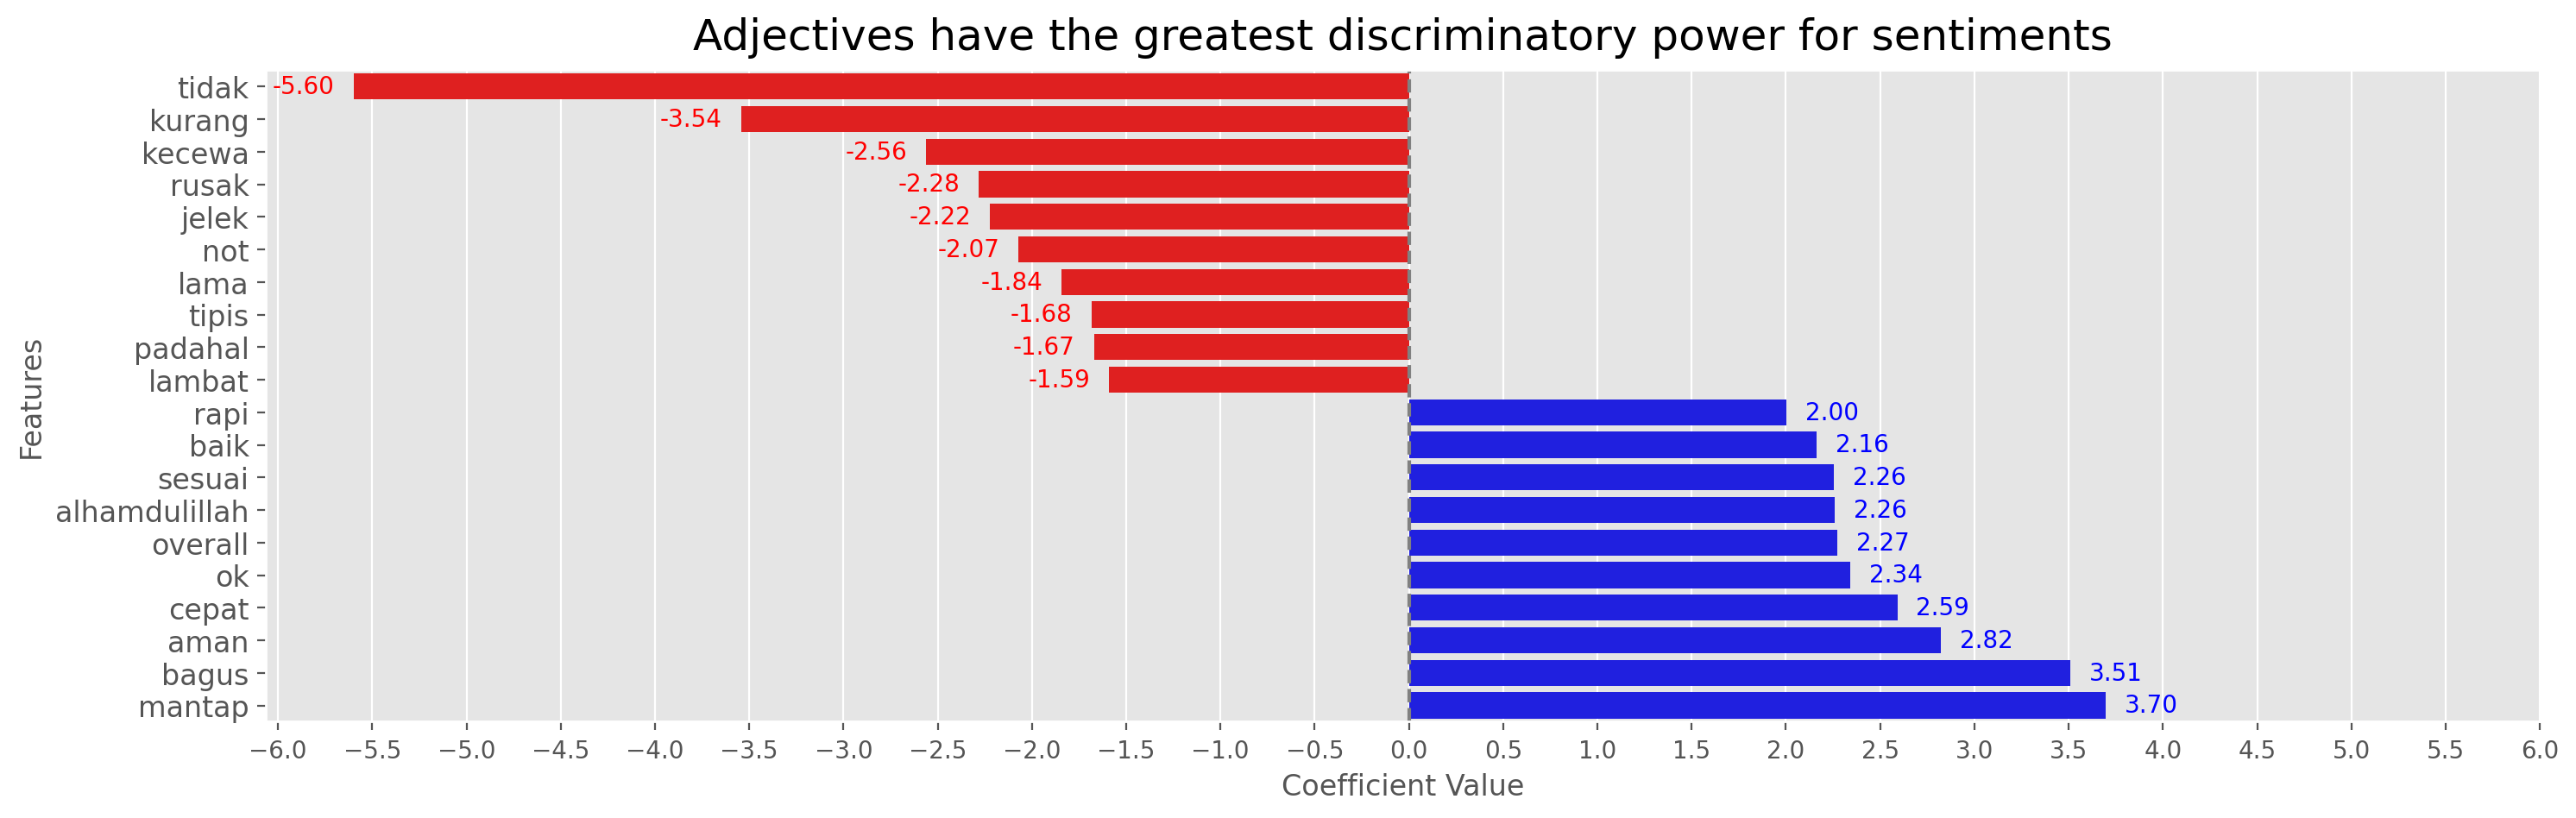

In [49]:
# create diverging bar chart
plt.figure(figsize=(17, 5), dpi=200)
sns.barplot(x='Coefficient', y='Feature', data=top_features_df, palette=top_features_df['Color'])
plt.axvline(0, color='grey', linestyle='--')  # add a vertical line at 0
plt.xticks(np.arange(-6, 6.5, 0.5))
plt.yticks(size=12)
plt.title('Adjectives have the greatest discriminatory power for sentiments',
          y=1.01, size=18)
plt.xlabel('Coefficient Value', size=12)
plt.ylabel('Features', size=12)

# add data labels
for index, row in top_features_df.iterrows():
    # adjust distance between bar and data label
    distance = 0.1
    x_pos = row['Coefficient'] + distance if row['Coefficient'] > 0 else row['Coefficient'] - distance
    plt.text(x_pos, index, f'{row["Coefficient"]:.2f}',
             color='blue' if row['Color'] == 'blue' else 'red',
             ha='left' if row['Coefficient'] > 0 else 'right',
             va='center', fontsize=10)
plt.show()

- berapa banyak kata tidak dan not di sentimen negatif? apakah ada instance yg punya sentimen positif dengan kata tidak dan not?

In [50]:
tidak_df = df[df['CleanReview'].str.contains('tidak')]
tidakNegative_df = df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Negative')]
tidakPositive_df = df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Positive')]
print(f'Total instances containing \'tidak\': {len(tidak_df)/len(df)*100:.2f}%')
print(f'- Total negative instances containing \'tidak\': {len(tidakNegative_df)/len(df)*100:.2f}%')
print(f'- Total positive instances containing \'tidak\': {len(tidakPositive_df)/len(df)*100:.2f}%')

Total instances containing 'tidak': 34.38%
- Total negative instances containing 'tidak': 28.69%
- Total positive instances containing 'tidak': 5.69%


In [51]:
# mantap_df = df[df['CleanReview'].str.contains('mantap')]
# mantapNegative_df = df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Negative')]
# mantapPositive_df = df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Positive')]
# print(f'Total instances containing \'tidak\': {len(mantap_df)/len(df)*100:.2f}%')
# print(f'- Total negative instances containing \'tidak\': {len(mantapNegative_df)/len(df)*100:.2f}%')
# print(f'- Total positive instances containing \'tidak\': {len(mantapPositive_df)/len(df)*100:.2f}%')

In [52]:
df[(df['CleanReview'].str.contains('tidak')) & (df['Sentiment'] == 'Negative')]['CleanReview']

41      jelek yang pasti jauh dari ori mousepad jadi t...
42                                    tidak bisa di pakai
44      kecewa penjual tidak tanggung jawab komplen be...
45      pas beli nanya dulu tipe untuk macbook pro inc...
48      tidak ada tissue pembersih atau alat bantuan l...
                              ...                        
5142    pengiriman sehari awalnya beli ini karena eksp...
5143                warna tidak sesuai dg yang diinginkan
5144    barang yang dikirim tidak sesuai promosi menge...
5145    sangat mengecewakan barang dikirim tidak sesua...
5148    parah barang rusak retak di komplain malah uru...
Name: CleanReview, Length: 1547, dtype: object

In [53]:
# display coefficient
eli5.show_weights(best_model.named_steps['classifier'], 
                  feature_names=vectorizer.get_feature_names_out())

### **5.3 Local Explanation: Text Explainer**

In [54]:
# Use vectorizer to transform the raw text instance into the required format
instance_raw = X_test.iloc[1]                               # Assuming X_test_raw contains raw text data
instance_vectorized = vectorizer.transform([instance_raw])  # Transform to the same format used for training

# Display the explanation
explanation = eli5.explain_prediction(best_model.named_steps['classifier'], instance_vectorized, 
                                       feature_names=vectorizer.get_feature_names_out())
eli5.show_prediction(best_model.named_steps['classifier'], instance_vectorized, 
                     feature_names=vectorizer.get_feature_names_out())

In [55]:
# prevent resetting index on X_test
X_test_raw = X_test
X_test_raw = X_test_raw.reset_index(drop=True)  

# init LIME for text data
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])

# Use instance for explanation
exp = explainer.explain_instance(X_test_raw[1], best_model.predict_proba)

# Show explanation 
exp.show_in_notebook(text=True)

In [56]:
# Original text
original_text = "Ikannya mati jadi saya kecewa"
counterfactual_text = "Ikannya mantap jadi saya kecewa"

# Step 1: Predict with the original text
original_prediction = (best_model.named_steps['classifier']
                       .predict_proba(vectorizer.transform([original_text]))[0])

# original_prediction_rounded = np.round(original_prediction, 4)
print(f"Original Text: {original_text}")
print(f"Prediction (Original): {np.round(original_prediction, 3)}")

# Step 2: Predict with the counterfactual text
counterfactual_prediction = (best_model.named_steps['classifier']
                             .predict_proba(vectorizer.transform([counterfactual_text]))[0])

# counterfactual_prediction_rounded = np.round(counterfactual_prediction, 4)
print(f"\nCounterfactual Text: {counterfactual_text}")
print(f"Prediction (Counterfactual): {np.round(counterfactual_prediction, 3)}")

# Step 3: Show comparison of predictions
if original_prediction[1] < counterfactual_prediction[1]:
    print("\nThe counterfactual text has a more positive sentiment.")
else:
    print("\nThe counterfactual text does not lead to a more positive sentiment.")

Original Text: Ikannya mati jadi saya kecewa
Prediction (Original): [1. 0.]

Counterfactual Text: Ikannya mantap jadi saya kecewa
Prediction (Counterfactual): [0.5 0.5]

The counterfactual text has a more positive sentiment.


In [57]:
# LIME explanation for original text
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
exp_original = explainer.explain_instance(original_text, best_model.predict_proba)
print("LIME explanation for original instance:")
exp_original.show_in_notebook(text=True)

# LIME explanation for counterfactual text
exp_counterfactual = explainer.explain_instance(counterfactual_text, best_model.predict_proba)
print("LIME explanation for counterfactual instance:")
exp_counterfactual.show_in_notebook(text=True)

LIME explanation for original instance:


LIME explanation for counterfactual instance:


### **5.4 Error Analysis**

In [58]:
# liat di gender prediction

### **5.5 Model Saving**

In [59]:
# Save the trained model to a file
print(f'Best model: {best_model}')
joblib.dump(best_model, '../model/best_model_tfidf.pkl')
print(f'Best model successfully saved!')

Best model: Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', SVC(C=1, kernel='linear', probability=True))])
Best model successfully saved!


<h1 style='color:orange; text-align:center; font-weight:bold'>---END---</h1>

### **5.3 Global Explanation: Feature Importance with Eli5**

```python
import eli5
from eli5.sklearn import PermutationImportance

# compute permutation importance
perm_importance = PermutationImportance(best_model.named_steps['classifier'], 
                                        random_state=42).fit(X_test_tfidf.toarray(), y_test)

# display results
eli5.show_weights(perm_importance, feature_names=vectorizer.get_feature_names_out())
```

### **5.4 Global Explanation: Permutation Importance**

```python
# convert sparse matrix to dense format
X_test_dense = X_test_tfidf.toarray() 

# perform permutation importance 
perm_importance = permutation_importance(best_model.named_steps['classifier'], 
                                         X_test_dense, y_test, n_repeats=10)

# get feature importance scores
importance_scores = perm_importance.importances_mean

# retrieve the feature names
feature_names = vectorizer.get_feature_names_out()

# create and sort df by importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# display top features
display(importance_df.head(10))

# create boxplot for permutation importance
plt.figure(figsize=(12, 6))
sns.boxplot(x='Importance', y='Feature', data=importance_df)
plt.title('Boxplot of Feature Importance from Permutation Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.axvline(0, color='grey', linestyle='--')  
plt.show()
```